In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import random
from torch.autograd import Variable
import copy
from torch import nn, optim
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv
import time
import math


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
fix_seed(SEED)

In [3]:
class Argments():
  def __init__(self):
    self.batch_size = 40
    self.test_batch = 1000
    self.global_epochs = 200
    self.local_epochs = 2
    self.lr = None
    self.momentum = 0.9
    self.weight_decay = 10**-4.0
    self.clip = 20.0
    self.partience = 10
    self.worker_num = 20
    self.sample_num = 20
    self.unlabeleddata_size = 1000
    self.device = torch.device('cuda:0'if torch.cuda.is_available() else'cpu')
    self.criterion = nn.CrossEntropyLoss()
    
    self.alpha_label = 0.5
    self.alpha_size = 10

args = Argments()

In [4]:
# Tuned value
lr = 2

In [6]:
lr_list = []
lr_list.append(10**-3.0)
lr_list.append(10**-2.5)
lr_list.append(10**-2.0)
lr_list.append(10**-1.5)
lr_list.append(10**-1.0)
lr_list.append(10**-0.5)
lr_list.append(10**0.0)
lr_list.append(10**0.5)

args.lr = lr_list[lr]

In [9]:
class LocalDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]
        if self.transform:
            out_data = self.transform(out_data)
        return out_data, out_label
    
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
class GlobalDataset(torch.utils.data.Dataset):
  def __init__(self,federated_dataset,transform=None):
    self.transform = transform
    self.data = []
    self.label = []
    for dataset in federated_dataset:
      for (data,label) in dataset:
        self.data.append(data)
        self.label.append(label)

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = self.label[idx]
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

class UnlabeledDataset(torch.utils.data.Dataset):
  def __init__(self,transform=None):
    self.transform = transform
    self.data = []
    self.target = None

  def __getitem__(self, idx):
    out_data = self.data[idx]
    out_label = 'unlabeled'
    if self.transform:
        out_data = self.transform(out_data)
    return out_data, out_label

  def __len__(self):
    return len(self.data)

In [10]:
def get_dataset(Centralized=False,unlabeled_data=False):
    
    transform_train = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomCrop(32, padding=2),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])
    transform_test = transforms.Compose([transforms.ToPILImage(),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.491372549, 0.482352941, 0.446666667), (0.247058824, 0.243529412, 0.261568627))])

    # download train data
    all_trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
    #trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

    # download test data
    all_testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True)
    #testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

    
    ## get unlabeled dataset
    if unlabeled_data:
        unlabeled_dataset = UnlabeledDataset(transform_test)
        idx = sorted(random.sample(range(len(all_trainset)),args.unlabeleddata_size))
        unlabeled_dataset.data = np.array([all_trainset.data[i]  for i in idx])
        all_trainset.data = np.delete(all_trainset.data,idx,0)
        all_trainset.targets = np.delete(all_trainset.targets,idx,0)
    all_train_data = np.array(all_trainset.data)
    all_train_label = np.array(all_trainset.targets)
    all_test_data = np.array(all_testset.data)
    all_test_label = np.array(all_testset.targets)
    print('Train:{} Test:{}'.format(len(all_train_data),len(all_test_data)))


    ## Data size heterogeneity
    data_proportions = np.random.dirichlet(np.repeat(args.alpha_size, args.worker_num))
    train_data_proportions = np.array([0 for _ in range(args.worker_num)])
    test_data_proportions = np.array([0 for _ in range(args.worker_num)])
    for i in range(len(data_proportions)):
        if i==(len(data_proportions)-1):
            train_data_proportions = train_data_proportions.astype('int64')
            test_data_proportions = test_data_proportions.astype('int64')
            train_data_proportions[-1] = len(all_train_data) - np.sum(train_data_proportions[:-1])
            test_data_proportions[-1] = len(all_test_data) - np.sum(test_data_proportions[:-1])
        else:
            train_data_proportions[i] = (data_proportions[i] * len(all_train_data))
            test_data_proportions[i] = (data_proportions[i] * len(all_test_data))
    min_size = 0
    K = 10

    '''
    label_list = np.arange(10)
    np.random.shuffle(label_list)
    '''
    label_list = list(range(K))


    ## Data distribution heterogeneity
    while min_size<10:
        idx_train_batch = [[] for _ in range(args.worker_num)]
        idx_test_batch = [[] for _ in range(args.worker_num)]
        for k in label_list:
            proportions_train = np.random.dirichlet(np.repeat(args.alpha_label, args.worker_num))
            proportions_test = copy.deepcopy(proportions_train)
            idx_k_train = np.where(all_train_label == k)[0]
            idx_k_test = np.where(all_test_label == k)[0]
            np.random.shuffle(idx_k_train)
            np.random.shuffle(idx_k_test)
            ## Balance (train)
            proportions_train = np.array([p*(len(idx_j)<train_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_train,idx_train_batch))])
            proportions_train = proportions_train/proportions_train.sum()
            proportions_train = (np.cumsum(proportions_train)*len(idx_k_train)).astype(int)[:-1]
            idx_train_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_train_batch,np.split(idx_k_train,proportions_train))]

            ## Balance (test)
            proportions_test = np.array([p*(len(idx_j)<test_data_proportions[i]) for i,(p,idx_j) in enumerate(zip(proportions_test,idx_test_batch))])
            proportions_test = proportions_test/proportions_test.sum()
            proportions_test = (np.cumsum(proportions_test)*len(idx_k_test)).astype(int)[:-1]
            idx_test_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_test_batch,np.split(idx_k_test,proportions_test))]

            min_size = min([len(idx_j) for idx_j in idx_train_batch])

    federated_trainset = []
    federated_testset = []
    for i in range(args.worker_num):
        ## create trainset
        data = [all_train_data[idx] for idx in idx_train_batch[i]]
        label = [all_train_label[idx] for idx in idx_train_batch[i]]
        federated_trainset.append(LocalDataset())
        federated_trainset[-1].data = data
        federated_trainset[-1].label = label

        ## create testset
        data = [all_test_data[idx] for idx in idx_test_batch[i]]
        label = [all_test_label[idx] for idx in idx_test_batch[i]]
        federated_testset.append(LocalDataset())
        federated_testset[-1].data = data
        federated_testset[-1].label = label

        
    ## split trainset
    federated_valset = [None]*args.worker_num
    for i in range(args.worker_num):
        n_samples = len(federated_trainset[i])
        if n_samples==1:
            train_subset = federated_trainset[i]
            val_subset = copy.deepcopy(federated_trainset[i])
        else:
            train_size = int(len(federated_trainset[i]) * 0.8) 
            val_size = n_samples - train_size 
            train_subset,val_subset = torch.utils.data.random_split(federated_trainset[i], [train_size, val_size])

        federated_trainset[i] = DatasetFromSubset(train_subset)
        federated_valset[i] = DatasetFromSubset(val_subset)

    ## show data distribution
    H = 4
    W = 5
    fig, axs = plt.subplots(H, W, figsize=(20, 5))
    x = np.arange(1,11)
    for i, (trainset,valset,testset) in enumerate(zip(federated_trainset,federated_valset,federated_testset)):
        bottom = [0]*10
        count = [0]*10
        for _,label in trainset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in valset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        for j in range(len(count)):
            bottom[j]+=count[j]
        count = [0]*10
        for _,label in testset:
            count[label] += 1
        axs[int(i/W), i%W].bar(x, count,bottom=bottom)
        #axs[int(i/W), i%W].title("worker{}".format(i+1), fontsize=12, color = "green")

    plt.show()

    ## get global dataset
    if Centralized:
        global_trainset = GlobalDataset(federated_trainset)
        global_valset = GlobalDataset(federated_valset)
        global_testset =  GlobalDataset(federated_testset)
        
        #show_cifer(global_trainset.data,global_testset.label, cifar10_labels)

        global_trainset.transform = transform_train
        global_valset.transform = transform_test
        global_testset.transform = transform_test

        global_trainloader = torch.utils.data.DataLoader(global_trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
        global_valloader = torch.utils.data.DataLoader(global_valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
        global_testloader = torch.utils.data.DataLoader(global_testset,batch_size=args.test_batch,shuffle=False,num_workers=2)

    ## set transform
    for i in range(args.worker_num):
        federated_trainset[i].transform = transform_train
        federated_valset[i].transform = transform_test
        federated_testset[i].transform = transform_test
    
    if Centralized and unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset
    if Centralized:
        return federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader
    elif unlabeled_data:
        return federated_trainset,federated_valset,federated_testset,unlabeled_dataset
    else:
        return federated_trainset,federated_valset,federated_testset

Files already downloaded and verified
Files already downloaded and verified
Train:49000 Test:10000


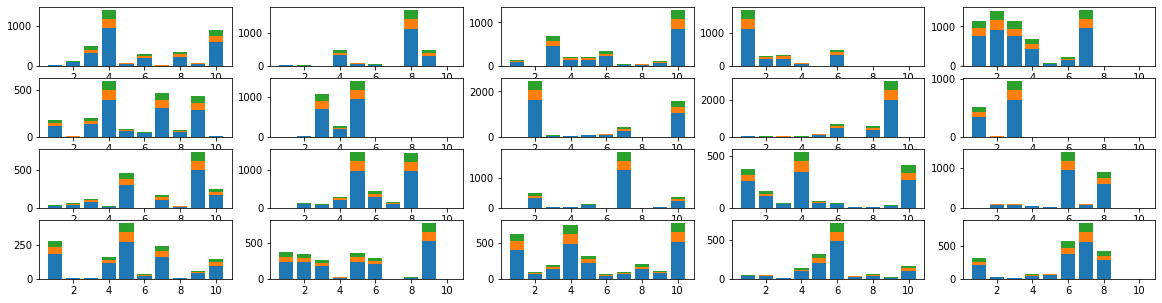

In [11]:
federated_trainset,federated_valset,federated_testset,global_trainloader,global_valloader,global_testloader,unlabeled_dataset = get_dataset(Centralized=True,unlabeled_data=True)

In [12]:
#federated_trainset,federated_valset,federated_testset,unlabeled_dataset = get_dataset(unlabeled_data=True)

In [13]:
total = [0,0,0]
for i in range(args.worker_num):
    total[0]+=len(federated_trainset[i])
    total[1]+=len(federated_valset[i])
    total[2]+=len(federated_testset[i])
print(total)

[39191, 9809, 10000]


In [15]:
class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            #print("in_channels: {}, v: {}".format(in_channels, v))
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


class VGGConvBlocks(nn.Module):
    '''
    VGG containers that only contains the conv layers 
    '''
    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class VGGContainer(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features, input_dim, hidden_dims, num_classes=10):
        super(VGGContainer, self).__init__()
        self.features = features
        # note: we hard coded here a bit by assuming we only have two hidden layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Linear(hidden_dims[1], num_classes),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def matched_vgg11(matched_shapes):
    # [(67, 27), (67,), (132, 603), (132,), (260, 1188), (260,), (261, 2340), (261,), (516, 2349), (516,), (517, 4644), (517,), 
    # (516, 4653), (516,), (516, 4644), (516,), (516, 515), (515,), (515, 515), (515,), (515, 10), (10,)]
    processed_matched_shape = [matched_shapes[0][0], 
                                'M', 
                                matched_shapes[2][0], 
                                'M', 
                                matched_shapes[4][0], 
                                matched_shapes[6][0], 
                                'M', 
                                matched_shapes[8][0], 
                                matched_shapes[10][0], 
                                'M', 
                                matched_shapes[12][0], 
                                matched_shapes[14][0], 
                                'M']
    return VGGContainer(make_layers(processed_matched_shape), input_dim=matched_shapes[16][0], 
            hidden_dims=[matched_shapes[16][1], matched_shapes[18][1]], num_classes=10)


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn(num_classes=10):
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes=num_classes)


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [16]:
class Server():
  def __init__(self):
    self.model = vgg13()

  def create_worker(self,federated_trainset,federated_valset,federated_testset):
    workers = []
    for i in range(args.worker_num):
      workers.append(Worker(federated_trainset[i],federated_valset[i],federated_testset[i]))
    return workers

  def sample_worker(self,workers):
    sample_worker = []
    sample_worker_num = random.sample(range(args.worker_num),args.sample_num)
    for i in sample_worker_num:
      sample_worker.append(workers[i])
    return sample_worker


  def send_model(self,workers):
    nums = 0
    for worker in workers:
      nums += worker.train_data_num

    for worker in workers:
      worker.aggregation_weight = 1.0*worker.train_data_num/nums
      worker.model = copy.deepcopy(self.model)
      worker.model = worker.model.to(args.device)

  def aggregate_model(self,workers):   
    new_params = OrderedDict()
    for i,worker in enumerate(workers):
      worker_state = worker.model.state_dict()
      for key in worker_state.keys():
        if i==0:
          new_params[key] = worker_state[key]*worker.aggregation_weight
        else:
          new_params[key] += worker_state[key]*worker.aggregation_weight
      worker.model = worker.model.to('cpu')
      del worker.model
    self.model.load_state_dict(new_params)

In [17]:
class Worker():
  def __init__(self,trainset,valset,testset):
    self.trainloader = torch.utils.data.DataLoader(trainset,batch_size=args.batch_size,shuffle=True,num_workers=2)
    self.valloader = torch.utils.data.DataLoader(valset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.testloader = torch.utils.data.DataLoader(testset,batch_size=args.test_batch,shuffle=False,num_workers=2)
    self.model = None
    self.train_data_num = len(trainset)
    self.test_data_num = len(testset)
    self.aggregation_weight = None

  def local_train(self):
    acc_train,loss_train = local_train(self.model,args.criterion,self.trainloader,args.local_epochs)
    acc_valid,loss_valid = test(self.model,args.criterion,self.valloader)
    return acc_train,loss_train,acc_valid,loss_valid

    

In [18]:
def local_train(model,criterion,trainloader,epochs):
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  model.train()
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    for (data,labels) in trainloader:
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      count += len(labels)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()

  return 100.0*correct/count,running_loss/len(trainloader)

In [19]:
def global_train(model,criterion,trainloader,valloader,epochs,partience=0,early_stop=False):
  if early_stop:
    early_stopping = Early_Stopping(partience)

  acc_train = []
  loss_train = []
  acc_valid = []
  loss_valid = []
  optimizer = optim.SGD(model.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    count = 0
    model.train()
    for (data,labels) in trainloader:
      count += len(labels)
      data,labels = Variable(data),Variable(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
      optimizer.step()
    acc_train.append(100.0*correct/count)
    loss_train.append(running_loss/len(trainloader))
        
    running_loss = 0.0
    correct = 0
    count = 0
    model.eval()
    for (data,labels) in valloader:
      count += len(labels)
      data,labels = data.to(args.device),labels.to(args.device)
      outputs = model(data)
      loss = criterion(outputs,labels)
      running_loss += loss.item()
      predicted = torch.argmax(outputs,dim=1)
      correct += (predicted==labels).sum().item()
      
    print('Epoch:{}  accuracy:{}  loss:{}'.format(epoch+1,100.0*correct/count,running_loss/len(valloader)))
    acc_valid.append(100.0*correct/count)
    loss_valid.append(running_loss/len(valloader))
    if early_stop:
      if early_stopping.validate(running_loss):
        print('Early Stop')
        return acc_train,loss_train,acc_valid,loss_valid

  return acc_train,loss_train,acc_valid,loss_valid

In [20]:
def test(model,criterion,testloader):
  model.eval()
  running_loss = 0.0
  correct = 0
  count = 0
  for (data,labels) in testloader:
    data,labels = data.to(args.device),labels.to(args.device)
    outputs = model(data)
    running_loss += criterion(outputs,labels).item()
    predicted = torch.argmax(outputs,dim=1)
    correct += (predicted==labels).sum().item()
    count += len(labels)

  accuracy = 100.0*correct/count
  loss = running_loss/len(testloader)


  return accuracy,loss

In [21]:
class Early_Stopping():
  def __init__(self,partience):
    self.step = 0
    self.loss = float('inf')
    self.partience = partience

  def validate(self,loss):
    if self.loss<loss:
      self.step += 1
      if self.step>self.partience:
        return True
    else:
      self.step = 0
      self.loss = loss

    return False

In [22]:
model = vgg13()
model = model.to(args.device)

start = time.time()
acc_train,loss_train,acc_valid,loss_valid = global_train(model,args.criterion,global_trainloader,global_valloader,args.global_epochs,partience=args.partience,early_stop=True)
end = time.time()

Epoch:1  accuracy:15.608114996431848  loss:2.274055314064026
Epoch:2  accuracy:29.850137628708328  loss:1.8576419234275818
Epoch:3  accuracy:37.11897237231114  loss:1.6468947887420655
Epoch:4  accuracy:42.481394637577736  loss:1.5116349816322328
Epoch:5  accuracy:46.997655214598836  loss:1.405281376838684
Epoch:6  accuracy:51.45274747680701  loss:1.2923513531684876
Epoch:7  accuracy:56.01998164950555  loss:1.1835212409496307
Epoch:8  accuracy:59.190539300642264  loss:1.1064811766147613
Epoch:9  accuracy:63.411153022734226  loss:1.0085255205631256
Epoch:10  accuracy:67.06086247323886  loss:0.9164419949054718
Epoch:11  accuracy:65.82730145784484  loss:0.9208846271038056
Epoch:12  accuracy:69.52798450402692  loss:0.8655185699462891
Epoch:13  accuracy:70.86349271077582  loss:0.8304315328598022
Epoch:14  accuracy:70.10908349474973  loss:0.8496272742748261
Epoch:15  accuracy:74.0544398001835  loss:0.745823347568512
Epoch:16  accuracy:73.0553573249057  loss:0.7718769162893295
Epoch:17  accura

In [24]:
server = Server()
workers = server.create_worker(federated_trainset,federated_valset,federated_testset)
server.model = model

In [25]:
acc_test = []
loss_test = []

server.model.to(args.device)

nums = 0
for worker in workers:
  nums += worker.test_data_num

start = time.time()

for i,worker in enumerate(workers):
  worker.aggregation_weight = 1.0*worker.test_data_num/nums
  acc_tmp,loss_tmp = test(server.model,args.criterion,worker.testloader)
  acc_test.append(acc_tmp)
  loss_test.append(loss_tmp)
  print('Worker{} accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))

end = time.time()

acc_test_avg = sum(acc_test)/len(acc_test)
loss_test_avg = sum(loss_test)/len(loss_test)
print('Test  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 accuracy:76.95852534562212  loss:0.8892805576324463
Worker2 accuracy:84.42622950819673  loss:0.6386640071868896
Worker3 accuracy:85.33333333333333  loss:0.6122786402702332
Worker4 accuracy:87.5  loss:0.4714757204055786
Worker5 accuracy:85.65853658536585  loss:0.5955828726291656
Worker6 accuracy:78.83008356545962  loss:0.9106189608573914
Worker7 accuracy:78.10526315789474  loss:0.804499089717865
Worker8 accuracy:89.03775883069427  loss:0.4709402918815613
Worker9 accuracy:87.64331210191082  loss:0.5057756900787354
Worker10 accuracy:80.55555555555556  loss:0.7536396384239197
Worker11 accuracy:89.2063492063492  loss:0.5061701536178589
Worker12 accuracy:84.89208633093526  loss:0.5809253454208374
Worker13 accuracy:92.65306122448979  loss:0.2531377971172333
Worker14 accuracy:81.37931034482759  loss:0.732693612575531
Worker15 accuracy:82.57080610021787  loss:0.6368874907493591
Worker16 accuracy:83.84279475982532  loss:0.6855120658874512
Worker17 accuracy:87.26415094339623  loss:0.62193

In [27]:
acc_tune_test = []
loss_tune_test = []
acc_tune_valid = []
loss_tune_valid = []

start = time.time()

for i,worker in enumerate(workers):
    worker.model = copy.deepcopy(server.model)
    worker.model = worker.model.to(args.device)
    _,_,acc_tmp,loss_tmp = worker.local_train()
    acc_tune_valid.append(acc_tmp)
    loss_tune_valid.append(loss_tmp)
    print('Worker{} Valid accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    
    acc_tmp,loss_tmp = test(worker.model,args.criterion,worker.testloader)
    acc_tune_test.append(acc_tmp)
    loss_tune_test.append(loss_tmp)
    print('Worker{} Test accuracy:{}  loss:{}'.format(i+1,acc_tmp,loss_tmp))
    worker.model = worker.model.to('cpu')
    del worker.model

end = time.time()

acc_valid_avg = sum(acc_tune_valid)/len(acc_tune_valid)
loss_valid_avg = sum(loss_tune_valid)/len(loss_tune_valid)
print('Validation(tune)  loss:{}  accuracy:{}'.format(loss_valid_avg,acc_valid_avg))
acc_test_avg = sum(acc_tune_test)/len(acc_tune_test)
loss_test_avg = sum(loss_tune_test)/len(loss_tune_test)
print('Test(tune)  loss:{}  accuracy:{}'.format(loss_test_avg,acc_test_avg))

Worker1 Valid accuracy:87.83151326053041  loss:0.5195301175117493
Worker1 Test accuracy:84.94623655913979  loss:0.5430549383163452
Worker2 Valid accuracy:92.32365145228216  loss:0.3624081611633301
Worker2 Test accuracy:90.77868852459017  loss:0.41827142238616943
Worker3 Valid accuracy:85.9375  loss:0.5839946269989014
Worker3 Test accuracy:87.23809523809524  loss:0.519051194190979
Worker4 Valid accuracy:89.4949494949495  loss:0.4020896852016449
Worker4 Test accuracy:89.48412698412699  loss:0.36940497159957886
Worker5 Valid accuracy:86.35458167330677  loss:0.7159607410430908
Worker5 Test accuracy:89.17073170731707  loss:0.2540260162204504
Worker6 Valid accuracy:86.93181818181819  loss:0.5281125903129578
Worker6 Test accuracy:85.51532033426184  loss:0.6875086426734924
Worker7 Valid accuracy:90.36402569593147  loss:0.30584174394607544
Worker7 Test accuracy:88.21052631578948  loss:0.43742257356643677
Worker8 Valid accuracy:93.54838709677419  loss:0.21323427557945251
Worker8 Test accuracy:92